Implementation of : http://cs229.stanford.edu/proj2012/ShenJiangZhang-StockMarketForecastingusingMachineLearningAlgorithms.pdf

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from __future__ import print_function

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15,6)

/Users/abhi/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Data Preprocessing

In [2]:
input_data_path = 'Data/'

In [3]:
analysis_symbol = "NSEI"
available_col_list = ['N225', 'HSI', 'AXJO', 'AUD', 'JPY', 'HKD', 'GC', 'SI', 'PL', 'CB']
unavailable_col_list = ['NSEI', 'GDAXI', 'IXIC', 'DJI', 'GSPC', 'FTSE', 'EUR', 'GBP', 'INR']

In [4]:
# Required as format of group is different from other group as obtained from several different sources.

nifty50_fnm = [('NSEI', '^NSEI.csv')]
indices_fnm1 = [('IXIC', '^IXIC.csv'), ('DJI', '^DJI.csv'), ('GSPC', '^GSPC.csv'),
               ('N225', '^N225.csv'), ('HSI', '^HSI.csv'), ('GDAXI', '^GDAXI.csv'),
               ('AXJO', '^AXJO.csv')]
indices_fnm2 = [('FTSE', '^FTSE.csv')]
currency_fnm = [('EUR', 'EUR_USD.csv'), ('AUD', 'AUD_USD.csv'), ('JPY', 'USD_JPY.csv'),
                ('HKD', 'USD_HKD.csv'), ('GBP', 'GBP_USD.csv'), ('INR', 'USD_INR.csv')]
commodity_fnm = [('GC', 'gc.f.csv'), ('SI', 'si.f.csv'), ('PL', 'pl.f.csv'), ('CB', 'cb.f.csv')]

In [5]:
def load_data(nm, fnm, date_format, req_col_nm):
    df = pd.read_csv(input_data_path + fnm)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    df[nm] = pd.to_numeric(df[req_col_nm], errors='coerce')
    return(df[nm])

In [6]:
df_list = []
start_date = datetime(2001,1,3).date()
end_date = datetime(2012,10,25).date()
# end_date = datetime(2018,3,29).date()

for nm,fnm in nifty50_fnm:
    df = load_data(nm, fnm, '%d %b %Y', 'Close')
    df_list.append(df)
for nm,fnm in indices_fnm1:
    df = load_data(nm, fnm, '%Y-%m-%d', 'Adj Close')
    df_list.append(df)
for nm,fnm in indices_fnm2:
    df = load_data(nm, fnm, '%b %d %Y', 'Price')
    df_list.append(df)
for nm,fnm in currency_fnm:
    df = load_data(nm, fnm, '%b %d, %Y', 'Price')
    df_list.append(df)
for nm,fnm in commodity_fnm:
    df = load_data(nm, fnm, '%Y-%m-%d', 'Close')
    df_list.append(df)
    
df = pd.concat(df_list, axis=1)
df = df.reset_index()
df = df[(df['Date']>=start_date) & (df['Date']<=end_date)] # Selecting date range where all the variable are available
df.set_index('Date', inplace=True)
df.tail(50)

,NSEI,IXIC,DJI,GSPC,N225,HSI,GDAXI,AXJO,FTSE,EUR,AUD,JPY,HKD,GBP,INR,GC,SI,PL,CB
Date,,,,,,,,,,,,,,,,,,,
2012-08-20,NaN,3076.209961,13271.639648,1418.130005,9171.160156,20104.269531,7033.680176,4364.299805,5824.37,1.2344,1.0444,79.42,7.7572,1.5711,55.505,1620.85,2874.0,1493.20,113.61
2012-08-21,5421.00,3067.260010,13203.580078,1413.170044,9156.919922,20100.089844,7089.319824,4383.399902,5857.52,1.2472,1.0488,79.28,7.7568,1.5784,55.310,1638.45,2925.5,1510.55,114.86
2012-08-22,5412.85,3073.669922,13172.759766,1413.489990,9131.740234,19887.779297,7017.750000,4376.000000,5774.20,1.2528,1.0505,78.58,7.7563,1.5881,55.500,1654.15,2976.7,1537.70,115.03
2012-08-23,5415.35,3053.399902,13057.459961,1402.079956,9178.120117,20132.240234,6949.569824,4383.700195,5776.60,1.2564,1.0440,78.48,7.7564,1.5859,55.265,1671.05,3052.3,1546.30,114.44
2012-08-24,5386.70,3069.790039,13157.969727,1411.130005,9070.759766,19880.029297,6971.069824,4349.000000,5776.60,1.2513,1.0404,78.67,7.7569,1.5812,55.505,1670.75,3073.5,1550.45,113.47
2012-08-27,5350.25,3073.189941,13124.669922,1410.439941,9085.389648,19798.669922,7047.450195,4343.700195,NaN,1.2500,1.0371,78.75,7.7561,1.5794,55.695,1663.65,3075.2,1544.15,112.59
2012-08-28,5334.60,3077.139893,13102.990234,1409.300049,9033.290039,19811.800781,7002.680176,4359.399902,5775.71,1.2565,1.0376,78.51,7.7562,1.5818,55.665,1667.15,3092.8,1519.30,112.40
2012-08-29,5287.80,3081.189941,13107.480469,1410.489990,9069.809570,19788.509766,7010.569824,4356.399902,5743.53,1.2529,1.0352,78.70,7.7556,1.5833,55.705,1656.45,3076.7,1517.00,112.78
2012-08-30,5315.05,3048.709961,13000.709961,1399.479980,8983.780273,19552.910156,6895.490234,4315.700195,5719.45,1.2506,1.0290,78.62,7.7561,1.5786,55.635,1655.35,3048.7,1508.55,112.79


#### Analysing Null values and filling with previous value whenever possible

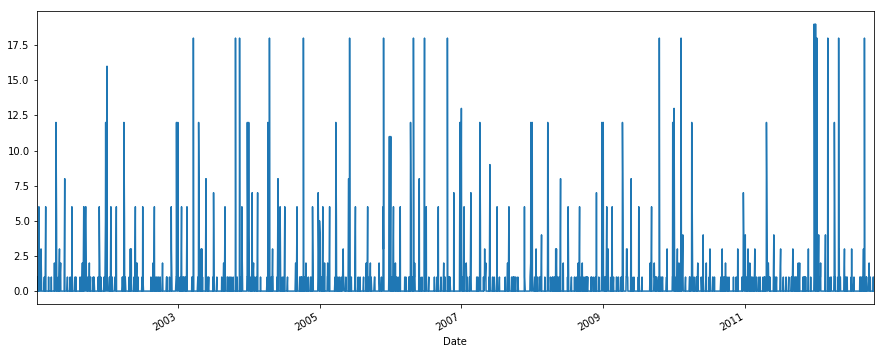

In [7]:
df.isnull().sum(axis=1).plot()

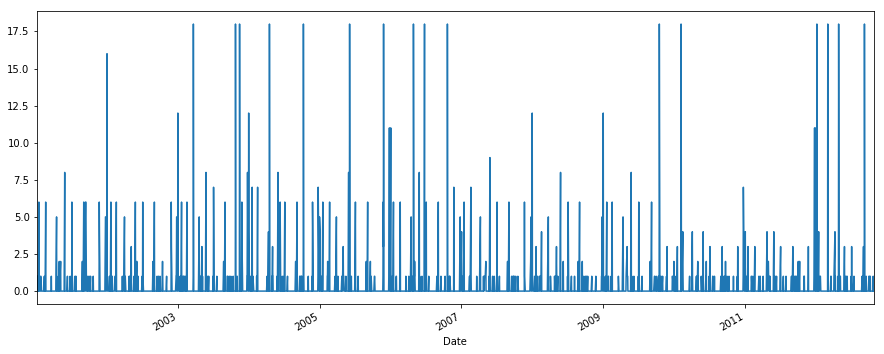

In [8]:
df1 = df.dropna(subset=[analysis_symbol])
df1.isnull().sum(axis=1).plot()

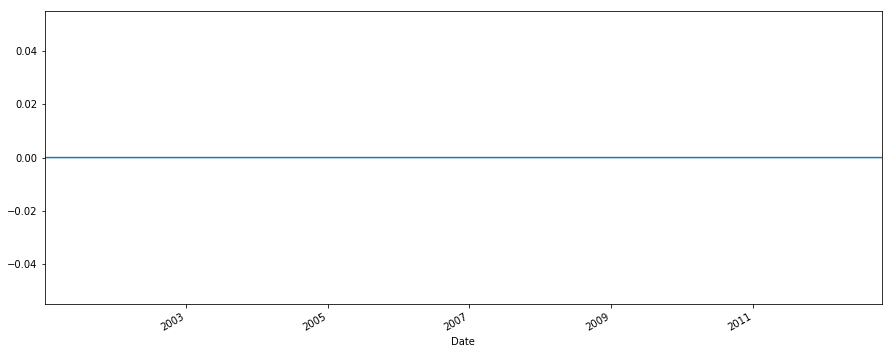

In [9]:
df2 = df1.fillna(method='ffill')
df2.dropna(inplace=True)
df2.isnull().sum(axis=1).plot()

# Temporal Correlation with Indices and Commodities

In [10]:
def delta_day_return(df, delta):
# Calculates moving returns over last delta days
    dfr = pd.DataFrame()
    for col in df.columns:
        dfr[col] = df[col].pct_change(periods=delta)
    return(dfr)

def cross_corr(x, df, start_lag, end_lag):
# Calculates cross correlation of x with all columns in df for all possible lags in between start_lag and end_lag
    corr_val = []
    for lag in range(start_lag, end_lag+1):
        corr_val_lag = []
        for col in df.columns:
            corr_val_lag.append(x.corr(df[col].shift(lag)))
        corr_val.append(corr_val_lag)
    return(pd.DataFrame(corr_val, index=range(start_lag, end_lag+1), columns=df.columns))

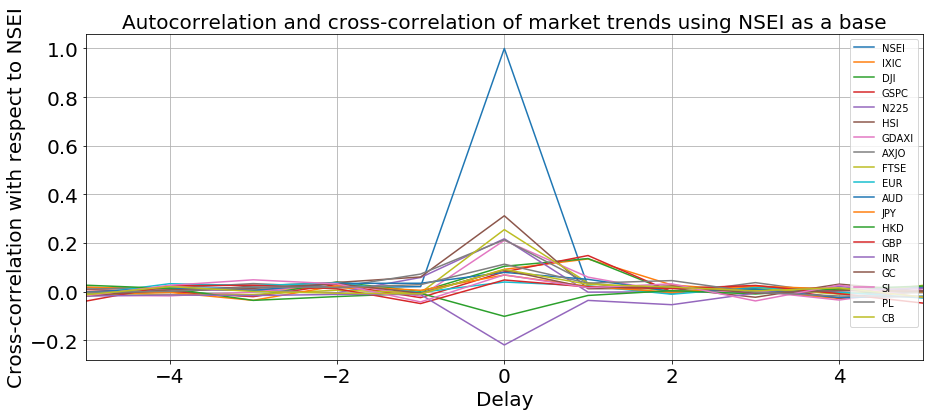

In [11]:
df3 = delta_day_return(df2,1)
df3 = df3.div(abs(df3))
df3.dropna(inplace=True)
corr_df = cross_corr(df3[analysis_symbol], df3, -5, 5)
corr_df.plot()
plt.grid()
plt.ylabel('Cross-correlation with respect to {}'.format(analysis_symbol), fontsize=20)
plt.xlabel('Delay', fontsize=20)
plt.title('Autocorrelation and cross-correlation of market trends using {} as a base'.format(analysis_symbol),
          fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

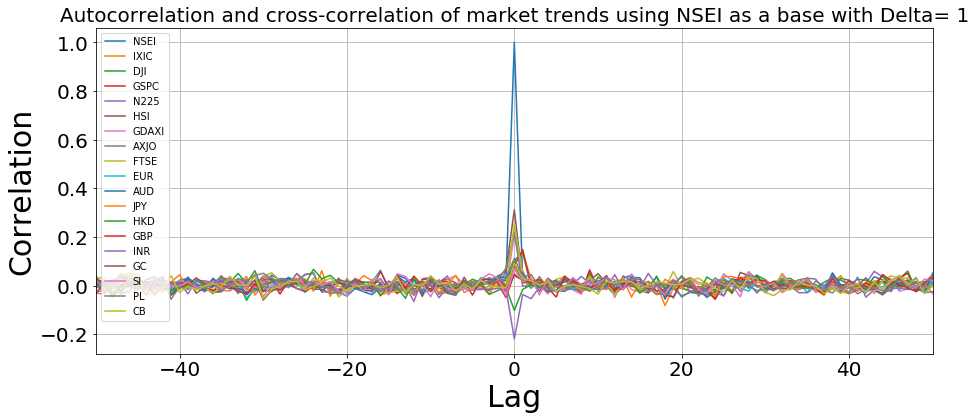

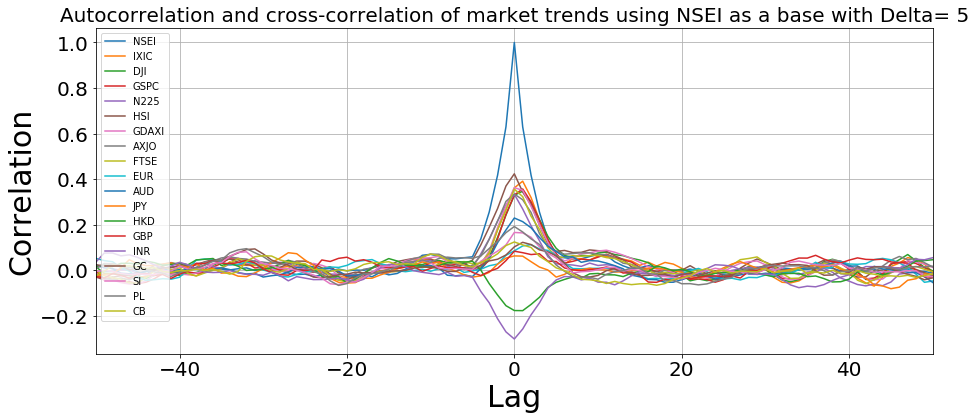

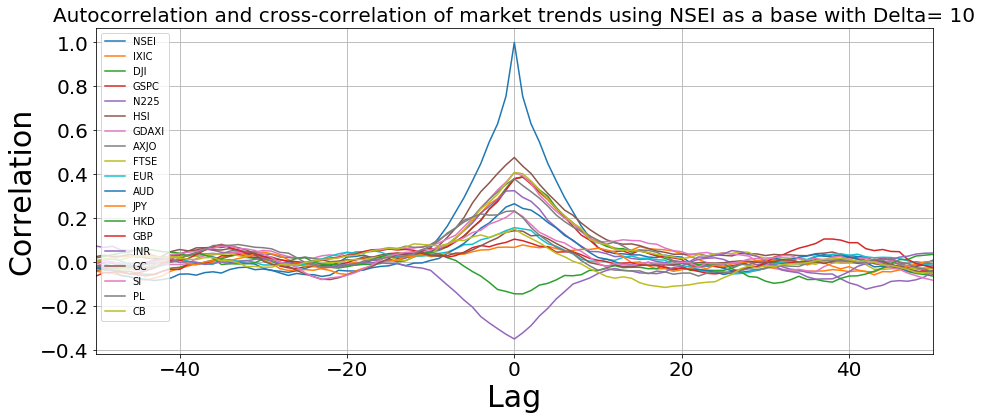

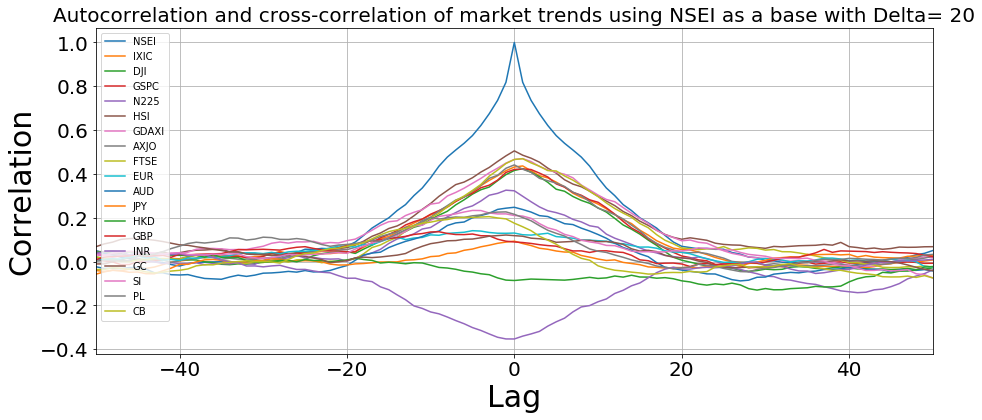

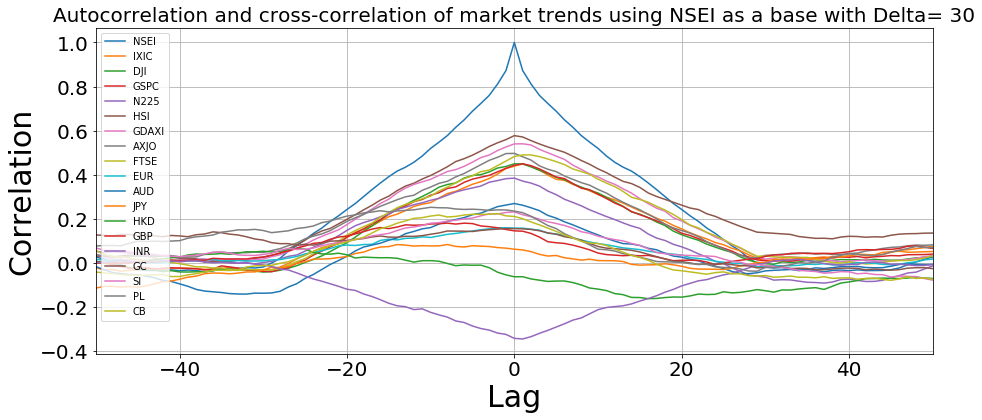

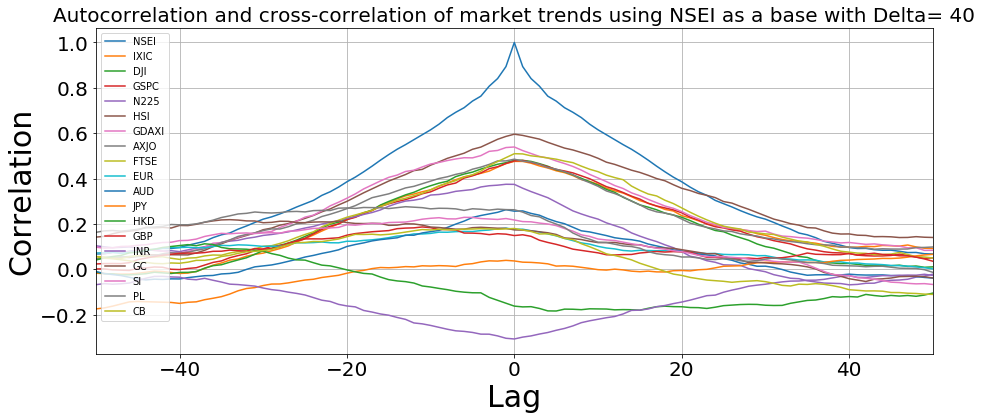

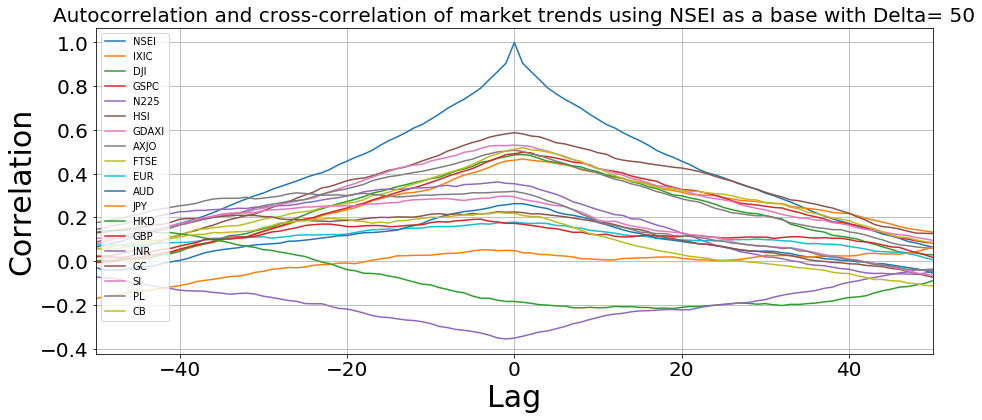

In [12]:
delta_list = [1,5,10,20,30,40,50]
for delta in delta_list:
    df6 = delta_day_return(df2,delta)
    df6 = df6.div(abs(df6))
    df6.dropna(inplace=True)
    corr_df = cross_corr(df6[analysis_symbol], df6, -50, 50)
    corr_df.plot()
    plt.grid()
    plt.ylabel('Correlation', fontsize=30)
    plt.xlabel('Lag', fontsize=30)
    plt.title('Autocorrelation and cross-correlation of market trends using {0} as a base with Delta= {1}'
              .format(analysis_symbol, str(delta)), fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(loc='upper left')

## Trend Prediction using Single Feature

In [13]:
print(__doc__)

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
# n_samples = all_features_df.shape[0]
X1 = df3[['GDAXI']]
y1 = df3[analysis_symbol]

# Split the dataset in two equal parts
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(solver='lbfgs'), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X1_train, y1_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y1_test, clf.predict(X1_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/li

Best parameters set found on development set:

{'C': 0.01}

Grid scores on development set:

0.263 (+/-0.000) for {'C': 0.001}
0.594 (+/-0.046) for {'C': 0.01}
0.594 (+/-0.046) for {'C': 0.1}
0.594 (+/-0.046) for {'C': 1}
0.594 (+/-0.046) for {'C': 10}
0.594 (+/-0.046) for {'C': 100}
0.594 (+/-0.046) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

        -1.0       0.58      0.59      0.58       451
         1.0       0.65      0.65      0.65       548

    accuracy                           0.62       999
   macro avg       0.62      0.62      0.62       999
weighted avg       0.62      0.62      0.62       999


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.01}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.001}
0.594 (+/-0.046) for {'C': 0.01}
0.594 (+/-0.046) fo

/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

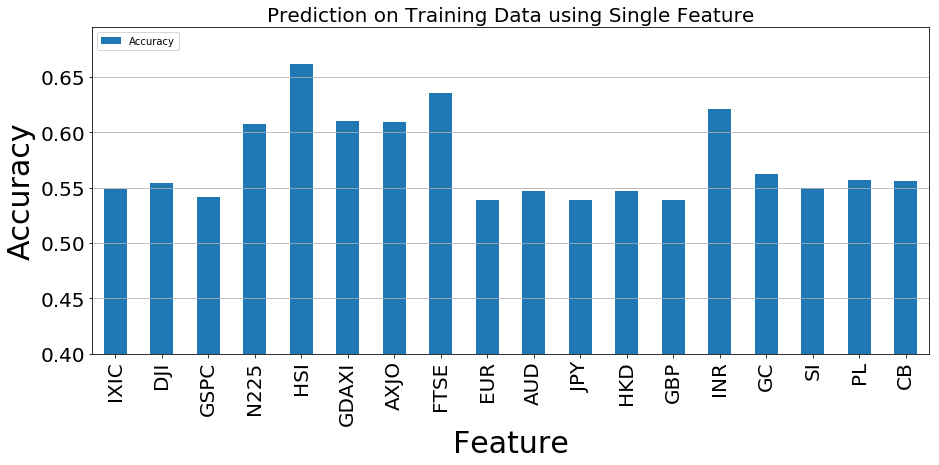

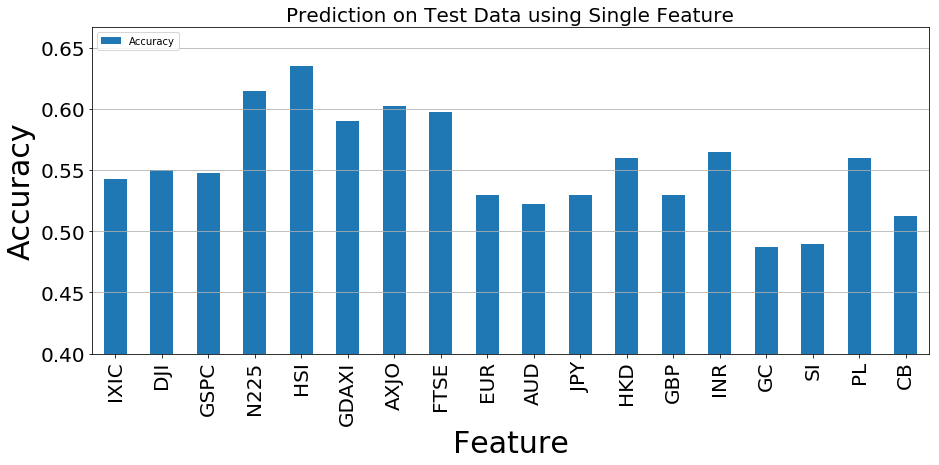

In [14]:
df7 = df2.copy()
df7.dropna(inplace=True)
df7 = delta_day_return(df7,1)
df7 = df7.div(abs(df7))
df7.dropna(inplace=True)
# df7['NSEI'] = df7['NSEI'].map(lambda x: 1 if(x>=0) else 0)
train_df, test_df = train_test_split(df7, test_size=0.2)
train_acc = []
test_acc = []
for col in train_df.columns:
    if(col != analysis_symbol):
        classifier = LogisticRegression(solver='warn', C=1, random_state=0)
        classifier.fit(train_df[[col]], train_df[analysis_symbol])
        train_acc.append((col, classifier.score(train_df[[col]], train_df[analysis_symbol])))
        test_acc.append((col, classifier.score(test_df[[col]], test_df[analysis_symbol])))
    
train_acc_df = pd.DataFrame(train_acc, columns=['Feature', 'Accuracy'])
train_acc_df.set_index('Feature', inplace=True)
ax = train_acc_df.plot.bar()
ax.yaxis.grid()
ax.set_ylim(bottom=0.4)
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Training Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

test_acc_df = pd.DataFrame(test_acc, columns=['Feature', 'Accuracy'])
test_acc_df.set_index('Feature', inplace=True)
ax = test_acc_df.plot.bar()
ax.yaxis.grid()
ax.set_ylim(bottom=0.4)
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Test Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

In [15]:
classifier

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
sum(train_df[analysis_symbol]==1)/len(train_df[analysis_symbol]) # Fraction of positive movements in training data (same as training acc)

0.5385097056981841

In [19]:
cm = confusion_matrix(test_df[analysis_symbol], classifier.predict(test_df[['HSI']]))
print(cm)

[[124  64]
 [ 82 130]]


/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

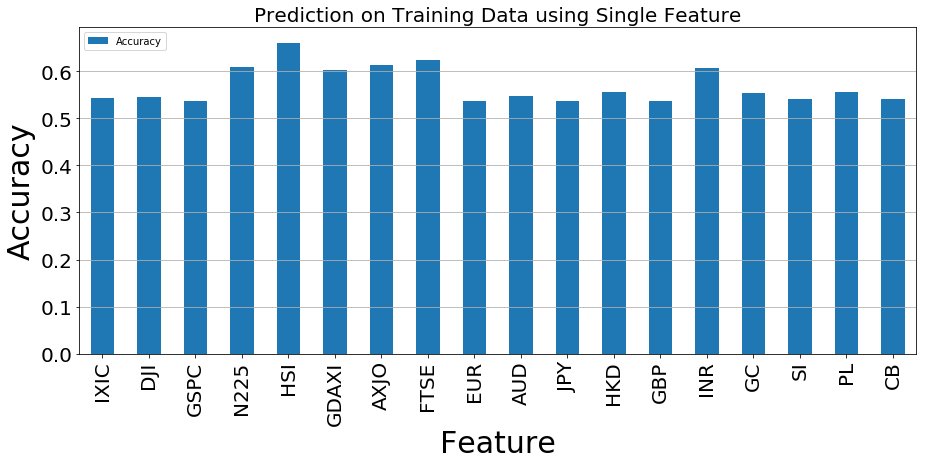

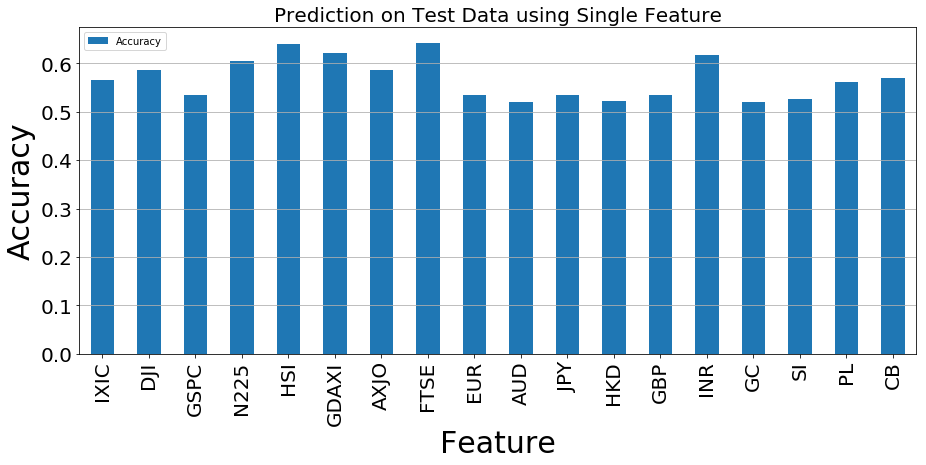

In [20]:
df7 = df2.copy()
df7.dropna(inplace=True)
df7 = delta_day_return(df7,1)
df7 = df7.div(abs(df7))
df7.dropna(inplace=True)
# df7['NSEI'] = df7['NSEI'].map(lambda x: 1 if(x>=0) else 0)
train_df, test_df = train_test_split(df7, test_size=0.2)
train_acc = []
test_acc = []
for col in train_df.columns:
    if(col != analysis_symbol):
        classifier = LogisticRegression(solver='warn', C=100, random_state=0)
        classifier.fit(train_df[[col]], train_df[analysis_symbol])
        train_acc.append((col, classifier.score(train_df[[col]], train_df[analysis_symbol])))
        test_acc.append((col, classifier.score(test_df[[col]], test_df[analysis_symbol])))
    
train_acc_df = pd.DataFrame(train_acc, columns=['Feature', 'Accuracy'])
train_acc_df.set_index('Feature', inplace=True)
ax = train_acc_df.plot.bar()
ax.yaxis.grid()
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Training Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

test_acc_df = pd.DataFrame(test_acc, columns=['Feature', 'Accuracy'])
test_acc_df.set_index('Feature', inplace=True)
ax = test_acc_df.plot.bar()
ax.yaxis.grid()
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Test Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

In [21]:
classifier

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Multi Feature Prediction

In [22]:
unavailable_lagged_df = df2[unavailable_col_list].shift(1)
unavailable_lagged_df.columns = [col + "_1" for col in unavailable_lagged_df]
all_df_list = [df2[available_col_list], unavailable_lagged_df]
df_t = pd.concat(all_df_list, axis=1)
df_t.dropna(inplace=True)

In [23]:
delta_list = [1,5,10,20,30,40,50]
target = delta_day_return(df2[[analysis_symbol]],1)
target = target.div(abs(target))

features_df_list = [target]
for delta in delta_list:
    df7 = delta_day_return(df_t,delta)
    df7 = df7.div(abs(df7))
    df7.columns = [x + '_d' + str(delta) for x in df7.columns]
    features_df_list.append(df7)
all_features_df = pd.concat(features_df_list, axis=1)
all_features_df.dropna(inplace=True)

In [24]:
train_df, test_df = train_test_split(all_features_df, test_size=0.2, random_state=0)

d1_col_list = [col for col in train_df.columns if(col[-3:]=="_d1")]
all_features_col_list = [col for col in train_df.columns if(col!=analysis_symbol)]
X_d1_train = train_df[d1_col_list]
X_train = train_df[all_features_col_list]
y_train = train_df[analysis_symbol]

X_d1_test = test_df[d1_col_list]
X_test = test_df[all_features_col_list]
y_test = test_df[analysis_symbol]

## Prediction using SVM
#### Using SVM on Features with lag=1

In [25]:
print(__doc__)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_d1_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_d1_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/li

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.659 (+/-0.026) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.272 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.669 (+/-0.024) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.659 (+/-0.025) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.669 (+/-0.024) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.669 (+/-0.024) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.663 (+/-0.044) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.669 (+/-0.024) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.669 (+/-0.024) for {'C': 1, 'kernel': 'linear'}
0.669 (+/-0.024) for {'C': 10, 'kernel': 'linear'}
0.669 (+/-0.024) for {'C': 100, 'kernel': 'linear'}
0.669 (+/-0.024) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             

In [26]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_d1_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_d1_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, clf.predict(X_d1_train)))))

cm_test = confusion_matrix(y_test, clf.predict(X_d1_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, clf.predict(X_d1_test)))))

Train Confusion Matrix:
[[357 189]
 [206 444]]
Train Accuracy: 0.669732441471572

Test Confusion Matrix:
[[ 97  48]
 [ 53 102]]
Test Accuracy: 0.6633333333333333


In [27]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

#### Using SVM on Features with all lag values (1,5,10,20,30,40,50)

In [28]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, clf.predict(X_train)))))

cm_test = confusion_matrix(y_test, clf.predict(X_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, clf.predict(X_test)))))

Train Confusion Matrix:
[[356 190]
 [150 500]]
Train Accuracy: 0.7157190635451505

Test Confusion Matrix:
[[ 93  52]
 [ 51 104]]
Test Accuracy: 0.6566666666666666


In [29]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Prediction using LightGBM
#### Using LightGBM on Features with lag=1

In [30]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 10
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_d1_train, label=y_train), 1000)
d1_train_pred = np.where(clf.predict(X_d1_train)>=thres, 1, -1)
d1_test_pred = np.where(clf.predict(X_d1_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, d1_train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, d1_train_pred))))

cm_test = confusion_matrix(y_test, d1_test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, d1_test_pred))))

Train Confusion Matrix:
[[350 196]
 [129 521]]
Train Accuracy: 0.7282608695652174

Test Confusion Matrix:
[[ 87  58]
 [ 41 114]]
Test Accuracy: 0.67


#### Using LightGBM on features with all lags

In [31]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['lambda'] = 1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_train, label=y_train), 1000)
train_pred = np.where(clf.predict(X_train)>=thres, 1, -1)
test_pred = np.where(clf.predict(X_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, train_pred))))

cm_test = confusion_matrix(y_test, test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, test_pred))))

Train Confusion Matrix:
[[362 184]
 [ 78 572]]
Train Accuracy: 0.7809364548494984

Test Confusion Matrix:
[[ 86  59]
 [ 43 112]]
Test Accuracy: 0.66


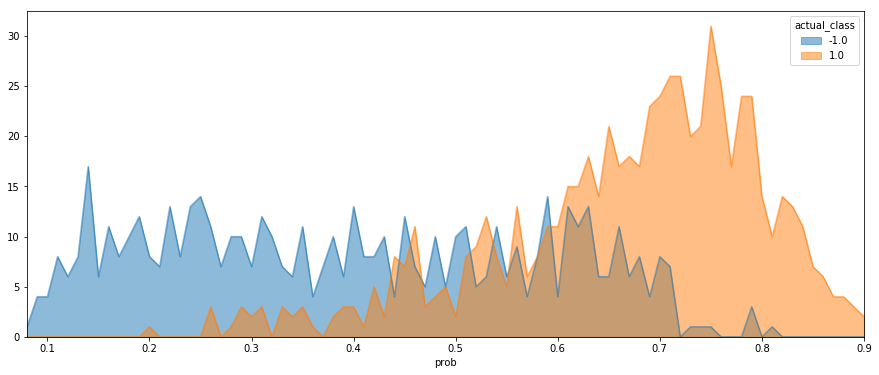

In [32]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_train.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_train).round(2))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

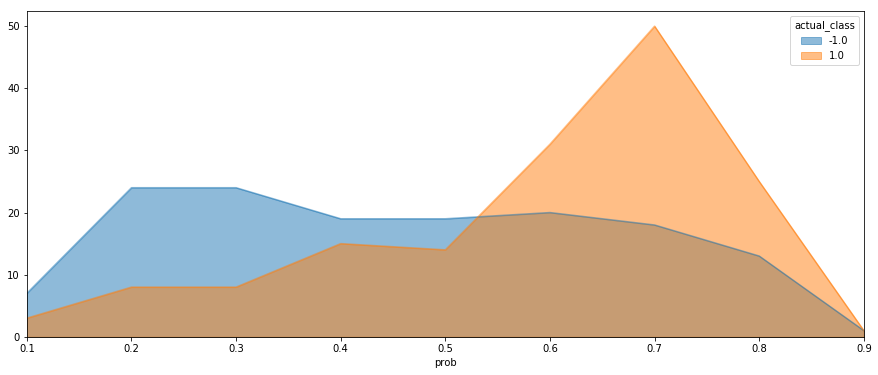

In [33]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_test.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_test).round(1))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

## Feature Selection

In [34]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(solver='lbfgs'),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'accuracy',
           cv = 5)

sfs.fit(X_train, y_train)
sfs.k_feature_names_

/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


('N225_d1',
 'HSI_d1',
 'AXJO_d1',
 'EUR_1_d1',
 'GBP_1_d1',
 'AXJO_d5',
 'NSEI_1_d5',
 'DJI_1_d10',
 'DJI_1_d30',
 'INR_1_d40')

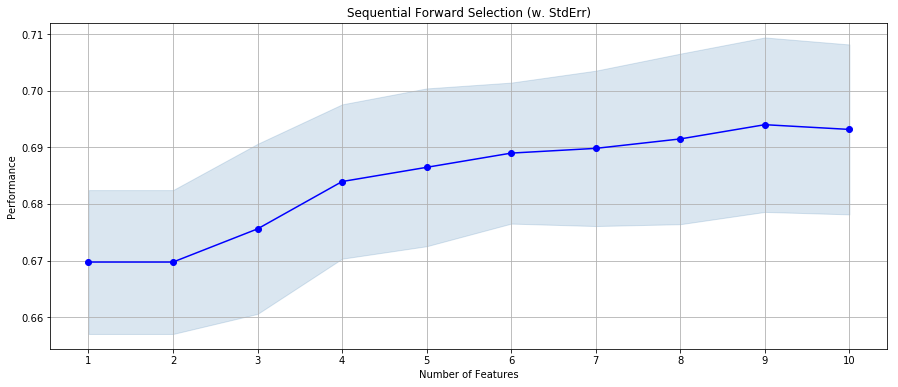

In [35]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [42]:
X_selected_features_train = X_train[list(sfs.k_feature_names_[:5])]
X_selected_features_test = X_test[list(sfs.k_feature_names_[:5])]

### SVM on selected Features

In [43]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_selected_features_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_selected_features_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(accuracy_score(y_train, clf.predict(X_selected_features_train))))

cm_test = confusion_matrix(y_test, clf.predict(X_selected_features_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(accuracy_score(y_test, clf.predict(X_selected_features_test))))

Train Confusion Matrix:
[[357 189]
 [206 444]]
Train Accuracy: 0.669732441471572

Test Confusion Matrix:
[[ 97  48]
 [ 53 102]]
Test Accuracy: 0.6633333333333333


### LightGBM on selected Features

In [44]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['lambda'] = 10
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_selected_features_train, label=y_train), 1000)
train_pred = np.where(clf.predict(X_selected_features_train)>=thres, 1, -1)
test_pred = np.where(clf.predict(X_selected_features_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(accuracy_score(y_train, train_pred)))

cm_test = confusion_matrix(y_test, test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(accuracy_score(y_test, test_pred)))

Train Confusion Matrix:
[[313 233]
 [149 501]]
Train Accuracy: 0.6806020066889632

Test Confusion Matrix:
[[ 79  66]
 [ 39 116]]
Test Accuracy: 0.65


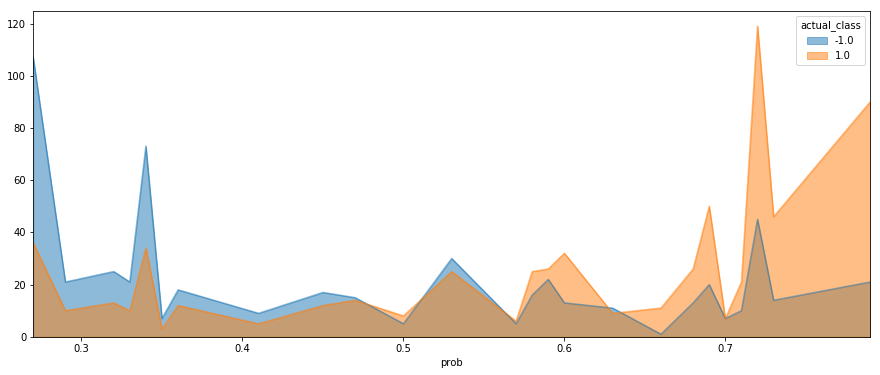

In [45]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_train.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_selected_features_train).round(2))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

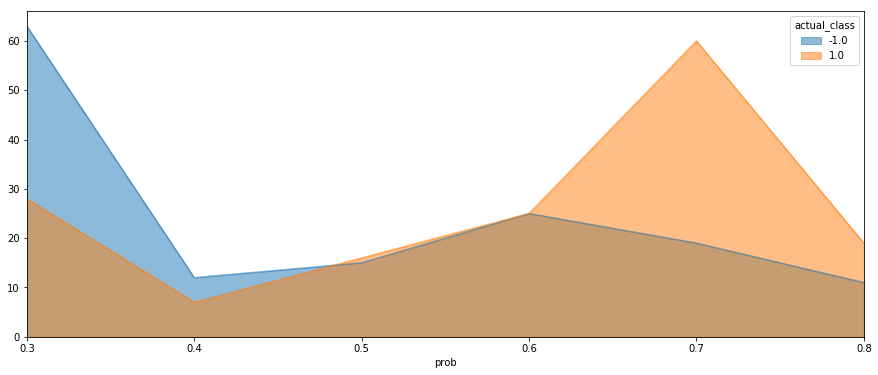

In [46]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_test.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_selected_features_test).round(1))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)